In [1]:
%%capture
!pip install mujoco==2.3.3

In [2]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


## **Importing Required Libraries**

This cell imports essential libraries for implementing and visualizing Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). The key components include:


In [3]:
from   torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.distributions import Normal
import random
import numpy as np
import logging
import matplotlib
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym



is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display



logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

## **Logging, Visualization, and Video Playback Functions**


In [4]:
def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## **Replay Memory for Experience Replay**

This class implements a **Replay Buffer**, a crucial component in off-policy reinforcement learning algorithms like DDPG and SAC. The buffer stores past experiences and allows the agent to sample them randomly, breaking correlation between consecutive samples and improving learning stability.

In [5]:
class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## **Neural Networks for DDPG and SAC**

This cell defines key neural networks used in **Deep Deterministic Policy Gradient (DDPG)** and **Soft Actor-Critic (SAC)** algorithms.


- **`GaussianPolicy`**: A stochastic policy for SAC, using Gaussian action sampling.
- **`DeterministicPolicy`**: A deterministic actor for DDPG, applying action bounds.

In [6]:
# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()

       # Define two separate Q-networks (Q1 and Q2) for twin Q-learning.
        self.linear1_1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear1_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear1_3 = nn.Linear(hidden_dim, 1)

        self.linear2_1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear2_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2_3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state, action):
        # Concatenate state and action as input and compute Q-values for both Q-networks.
        xu = torch.cat([state, action], dim=1)

        x1 = F.relu(self.linear1_1(xu))
        x1 = F.relu(self.linear1_2(x1))
        Q1 = self.linear1_3(x1)

        x2 = F.relu(self.linear2_1(xu))
        x2 = F.relu(self.linear2_2(x2))
        Q2 = self.linear2_3(x2)

        return Q1, Q2


LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space, device='cpu'):
        super(GaussianPolicy, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)


        # Compute action scaling and shifting factors based on the environment's action space.
        self.action_scale = torch.FloatTensor((action_space.high - action_space.low) / 2.0).to(device)
        self.action_bias = torch.FloatTensor((action_space.high + action_space.low) / 2.0).to(device)


    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
         # Use the reparameterization trick to sample from the Gaussian policy and apply action bounds.

        mean, log_std = self.forward(state)
        std = log_std.exp()

        # Create a Gaussian distribution
        normal = Normal(mean, std)

        # Reparameterization trick
        x_t = normal.rsample()


        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean



class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None,device = 'cpu'):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

       # Compute action scaling and shifting factors for deterministic policy.
        if action_space is not None:
            self.action_scale = torch.FloatTensor((action_space.high - action_space.low) / 2.0).to(device)
            self.action_bias = torch.FloatTensor((action_space.high + action_space.low) / 2.0).to(device)
        else:
            # default to [-1,1] range
            self.action_scale = torch.tensor(1.0).to(device)
            self.action_bias = torch.tensor(0.0).to(device)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = torch.tanh(self.mean(x)) * self.action_scale + self.action_bias
        return mean

    def sample(self, state):
         # Generate an action by adding noise to the deterministic policy for exploration.
        mean = self.forward(state)

        noise_std = 0.1
        self.noise = self.noise.normal_(0., noise_std).to(state.device)
        action = mean + self.noise

        log_prob = torch.tensor(0.).to(state.device)
        return action, torch.tensor(0.), mean


## **Soft Actor-Critic (SAC) Implementation - Explanation of the Cell**

This cell implements the **Soft Actor-Critic (SAC) algorithm**, a state-of-the-art off-policy reinforcement learning method for continuous control. The key idea behind SAC is to maximize both the **expected reward** and the **entropy** of the policy, promoting exploration and robustness.

### **Main Components in This Cell**
1. **Hyperparameters & Configuration**  
   - The algorithm's key parameters such as **discount factor** ($\gamma$), **soft update factor** ($\tau$), and **entropy coefficient** ($\alpha$) are set from the `config` dictionary.
   - **Entropy tuning** is optionally enabled to adjust $\alpha$ dynamically.

2. **Critic (Q-Networks)**
   - Two separate **Q-networks** (`self.critic` and `self.critic_target`) estimate the action-value function.
   - Using **twin Q-learning** (two critics) reduces overestimation bias.

3. **Actor (Policy Network)**
   - **Gaussian policy** is used when `policy_type="Gaussian"`, meaning actions are sampled from a probability distribution instead of being deterministic.
   - The policy is trained to maximize both expected rewards and entropy.
   - If the deterministic version (DDPG-like) is used, entropy is ignored ($\alpha = 0$).

4. **Action Selection (`select_action`)**
   - If `evaluate=False`, actions are sampled from the stochastic policy.
   - If `evaluate=True`, deterministic actions are chosen for testing.

5. **Parameter Update (`update_parameters`)**
   - **Sample a batch** from replay memory.
   - Compute **target Q-values** using the **minimum of the two Q-networks**.
   - Update **critic networks** by minimizing Bellman loss.
   - Update **policy** using the entropy-regularized objective.
   - If entropy tuning is enabled, update **$\alpha$** using.
   - Periodically **soft update** the target Q-network.


In [7]:

class SAC(object):
    def __init__(self, num_inputs, action_space, config):

        self.gamma = config['gamma']
        self.tau = config['tau']
        self.alpha = config['alpha']

        self.policy_type = config["policy"]
        self.target_update_interval = config["target_update_interval"]
        self.automatic_entropy_tuning = config['automatic_entropy_tuning']

        self.device = torch.device("cuda" if config['cuda'] else "cpu")

        self.critic = QNetwork(num_inputs, action_space.shape[0], config['hidden_size']).to(device=self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=config['lr'])

        self.critic_target = QNetwork(num_inputs, action_space.shape[0], config["hidden_size"]).to(self.device)
        self.hard_update(self.critic_target, self.critic)

        if self.policy_type == "Gaussian":
            # Target Entropy = −dim(A) (e.g. , -6 for HalfCheetah-v2) as given in the paper
            # Compute the target entropy for the Gaussian policy and initialize log_alpha for automatic entropy tuning.
            # The target entropy is typically set to -|A| (where A is the action space dimension), and log_alpha is initialized for optimization.
            action_dim = action_space.shape[0]
            self.target_entropy = -action_dim

            if self.automatic_entropy_tuning:
                # log_alpha is a learnable parameter. We'll exponentiate it to get alpha.
                self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
                self.alpha_optim = Adam([self.log_alpha], lr=config["lr"])

            self.policy = GaussianPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space,device = self.device).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=config["lr"])

        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space,device = self.device).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=config['lr'])

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        if evaluate is False:
        # Decide whether to sample from the policy or use the deterministic policy based on the evaluate flag.
            action, _, _ = self.policy.sample(state)
        else:
        # When evaluating, we typically use the deterministic policy, while during training, we use the exploration-based policy (stochastic).
            if self.policy_type == "Gaussian":
                # For GaussianPolicy, we often take the 'mean' output instead of a random sample
                # sample() returns (stochastic_action, log_prob, mean)
                _, _, deterministic_action = self.policy.sample(state)
                action = deterministic_action
            else:
                # For DeterministicPolicy, forward() is already deterministic
                action = self.policy.forward(state)

        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        # Sample a batch from memory
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * (min_qf_next_target)


        # Compute the Q-value loss using the Bellman backup and target Q-values.
        qf1, qf2 = self.critic(state_batch, action_batch)

        # The loss is typically the mean squared error between the Q-value predicted by the critic and the target Q-value.

        qf1_loss = F.mse_loss(qf1, next_q_value)
        qf2_loss = F.mse_loss(qf2, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)

        # Compute the policy loss by taking the minimum of the two Q-values and using the entropy bonus term.
        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)


        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean()

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()



        if self.automatic_entropy_tuning:
            # Compute the loss for tuning the entropy coefficient α.

            # The alpha loss encourages the entropy to be close to the target entropy, optimizing the entropy coefficient automatically.
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()
            self.alpha = self.log_alpha.exp().item()  # update alpha
            alpha_tlogs = self.log_alpha  # for logging
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha) # For TensorboardX logs


        if updates % self.target_update_interval == 0:
            self.soft_update(self.critic_target, self.critic, self.tau)

        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()


    # Hard and Soft updates
    # Implement soft update for target networks using Polyak averaging.
    def soft_update(self, target, source, tau):
        for t_param, s_param in zip(target.parameters(), source.parameters()):
            t_param.data.copy_(tau * s_param.data + (1.0 - tau) * t_param.data)

    # Soft update blends the target network with the source network using a factor tau, updating target gradually.

    def hard_update(self,target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)


## **Environment Setup and Initialization for SAC**

This cell sets up the environment and initializes the components needed to train the **Soft Actor-Critic (SAC)** agent.


In [ ]:
# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Gaussian",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.2,
    "seed":123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": True,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])




## **Training Loop for SAC Agent**

This cell contains the **training loop** for the Soft Actor-Critic (SAC) agent. The loop runs for a set number of episodes, where in each episode, the agent interacts with the environment, collects experiences, and updates its parameters.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 0, Avg Reward: -36.3
Episode: 10, Avg Reward: -76.74
Episode: 20, Avg Reward: 864.99
Episode: 30, Avg Reward: 540.85
Episode: 40, Avg Reward: 2202.99
Episode: 50, Avg Reward: 2837.61
Episode: 60, Avg Reward: 2823.05
Episode: 70, Avg Reward: 3613.85
Episode: 80, Avg Reward: 3886.86
Episode: 90, Avg Reward: 4328.74
Episode: 100, Avg Reward: 4573.84
Episode: 110, Avg Reward: 5076.84
Episode: 120, Avg Reward: 5474.12
Episode: 130, Avg Reward: 5721.32
Episode: 140, Avg Reward: 5924.62
Episode: 150, Avg Reward: 5957.19
Episode: 160, Avg Reward: 6597.62
Episode: 170, Avg Reward: 6862.81
Episode: 180, Avg Reward: 7219.19
Episode: 190, Avg Reward: 7300.98
Episode: 200, Avg Reward: 7508.57
Episode: 210, Avg Reward: 7655.57
Episode: 220, Avg Reward: 8005.74
Episode: 230, Avg Reward: 7963.9
Episode: 240, Avg Reward: 8116.56
Episode: 250, Avg Reward: 7963.85
Episode: 260, Avg Reward: 8274.87
Episode: 270, Avg Reward: 8453.14
Episode: 280, Avg Reward: 8469.83
Episode: 290, Avg Reward: 8410.

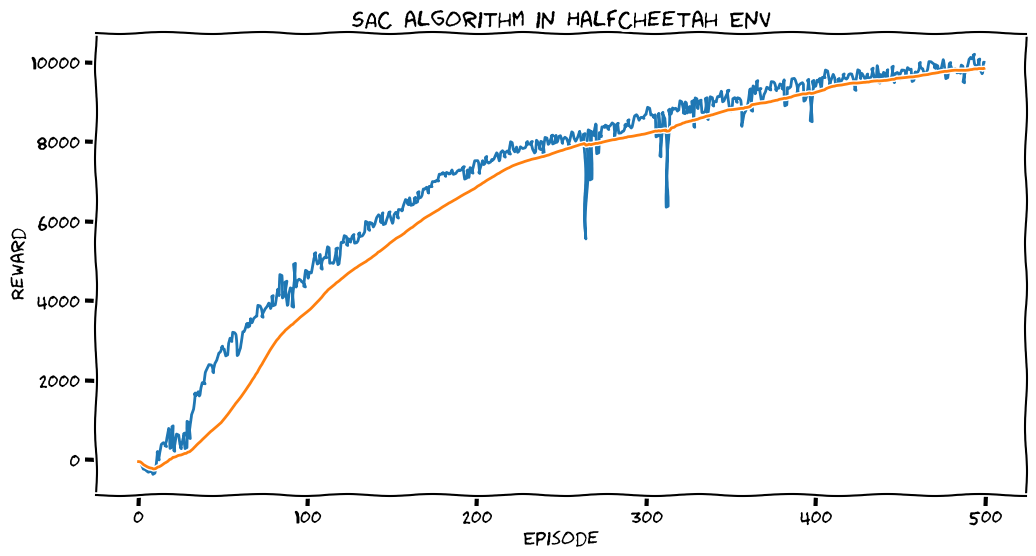

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
def evaluate_policy(env, agent, episodes=5):
    eval_reward = 0
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            # Use deterministic action
            action = agent.select_action(state, evaluate=True)
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            episode_reward += reward
            state = next_state

        eval_reward += episode_reward

    avg_reward = eval_reward / episodes
    return avg_reward

# Training Loop
total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 500
criteria = 0
max_reward = -1000
for i_episode in range(Max_episodes):
    episode_steps = 0
    done = False
    state, _ = env.reset()

    while not done:
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > config['batch_size']:
              critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, config['batch_size'], updates)
              updates += 1

        next_state, reward, done, truncated, _ = env.step(action) # Step
        episode_steps += 1
        total_numsteps +=1
        done = done or truncated

        # Ignore the "done" signal if it comes from hitting the time horizon.

        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state

    if i_episode % config["eval_interval"] == 0:
      avg_reward = evaluate_policy(env, agent, episodes=5)
      reward_history.append(avg_reward)

      # Print every 10 episodes for clarity
      if i_episode % 10 == 0:
          print(f"Episode: {i_episode}, Avg Reward: {round(avg_reward, 2)}")

      # Early stopping logic (if desired)
      if avg_reward < max_reward:
          criteria += 1
          if criteria == 50:  # if it's not improved for 50 consecutive evals
              print("Stopping early due to no improvement.")
              break
      else:
          criteria = 0
          max_reward = avg_reward


env.close()


plot_rewards(reward_history, show_result='SAC algorithm in HalfCheetah Env')

In [ ]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []
done = False
total_reward = 0
# run the policy in the environment in a loop
while not done:
    frames.append(env.render())
    action  = agent.select_action(state,evaluate=True)
    next_state, reward, done, truncated, _  = env.step(action)
    total_reward += reward

    done = done or truncated

    state = next_state

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_SAC.mp4', frames, fps=25)
show_video('./eval_SAC.mp4')

Total Reward: 9994.4536309938


# **Initialize DDPG**

In [11]:
# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Detreministic",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.05,
    "seed":123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": True,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])




/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


# **Train the DDPG here**

Episode: 0, Avg Reward: -548.62
Episode: 10, Avg Reward: -559.14
Episode: 20, Avg Reward: 261.9
Episode: 30, Avg Reward: 1213.6
Episode: 40, Avg Reward: 1068.59
Episode: 50, Avg Reward: 2862.23
Episode: 60, Avg Reward: 3710.12
Episode: 70, Avg Reward: 4018.87
Episode: 80, Avg Reward: 4223.36
Episode: 90, Avg Reward: 4398.27
Episode: 100, Avg Reward: 4580.66
Episode: 110, Avg Reward: 4957.35
Episode: 120, Avg Reward: 5027.0
Episode: 130, Avg Reward: 5287.18
Episode: 140, Avg Reward: 5218.26
Episode: 150, Avg Reward: 5287.18
Episode: 160, Avg Reward: 5770.92
Episode: 170, Avg Reward: 6061.03
Episode: 180, Avg Reward: 6193.81
Episode: 190, Avg Reward: 6252.29
Episode: 200, Avg Reward: 6427.62
Episode: 210, Avg Reward: 6540.7
Episode: 220, Avg Reward: 6858.19
Episode: 230, Avg Reward: 6974.36
Episode: 240, Avg Reward: 7145.24
Episode: 250, Avg Reward: 6830.11
Episode: 260, Avg Reward: 6871.27
Episode: 270, Avg Reward: 7328.58
Episode: 280, Avg Reward: 7339.6
Episode: 290, Avg Reward: 7429.

<ipython-input-4-12218de9f29c>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))


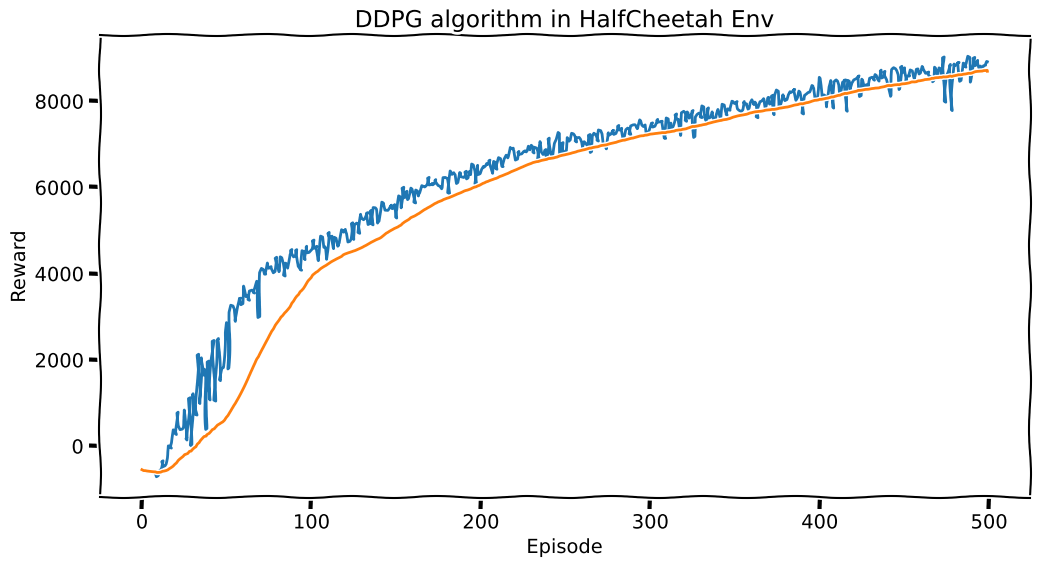

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [12]:
def evaluate_policy(env, agent, episodes=5):
    """
    Runs 'episodes' episodes using the current agent in deterministic mode.
    Returns the average total reward across these episodes.
    """
    eval_reward_sum = 0.0
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0.0

        while not done:
            # Select a *deterministic* action (agent.select_action with evaluate=True)
            action = agent.select_action(state, evaluate=True)
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            episode_reward += reward
            state = next_state

        eval_reward_sum += episode_reward

    avg_reward = eval_reward_sum / episodes
    return avg_reward

# Training Loop
total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 500
criteria = 0
max_reward = -1000
for i_episode in range(Max_episodes):
    episode_steps = 0
    done = False
    state, _ = env.reset()

    while not done:
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > config['batch_size']:
              critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, config['batch_size'], updates)
              updates += 1

        next_state, reward, done, truncated, _ = env.step(action) # Step
        episode_steps += 1
        total_numsteps +=1
        done = done or truncated

        # Ignore the "done" signal if it comes from hitting the time horizon.

        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state

    # Evaluate the policy at regular intervals and log the average reward.
    # Here, we are running evaluation episodes to measure how well the policy is performing over time.

    if i_episode % config["eval_interval"] == 0:
        avg_reward = evaluate_policy(env, agent, episodes=5)
        reward_history.append(avg_reward)


        if i_episode % 10 == 0:
            print(f"Episode: {i_episode}, Avg Reward: {round(avg_reward, 2)}")

        if avg_reward < max_reward:
            criteria += 1
            if criteria == 50:
                print("Stopping early due to no improvement for 50 evals.")
                break
        else:
            criteria = 0
            max_reward = avg_reward

env.close()


plot_rewards(reward_history, show_result='DDPG algorithm in HalfCheetah Env')

In [13]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []
done = False
total_reward = 0
# run the policy in the environment in a loop
while not done:
    frames.append(env.render())
    action  = agent.select_action(state,evaluate=True)
    next_state, reward, done, truncated, _  = env.step(action)
    total_reward += reward

    done = done or truncated

    state = next_state

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_DDPG.mp4', frames, fps=25)
show_video('./eval_DDPG.mp4')

Total Reward: 9048.801225757483
